# Fitting the properties of a star cluster using `isochrones`



In [1]:
# Simulate a cluster
import pickle

import numpy as np
import pandas as pd

from isochrones import get_ichrone
from isochrones.priors import PowerLawPrior
from isochrones.utils import addmags

resim = False
if resim:
    N = 40

    age = 8.56
    feh = -0.42
    distance = 200.
    AV = 0.0
    alpha = -3.
    gamma = 0.3
    fB = 0.5

    u = np.random.random(N)
    is_binary = u < fB

    pri_masses = PowerLawPrior(-3, (0.5, 2)).sample(N)
    qs = PowerLawPrior(gamma, (0.1, 1)).sample(N)
    sec_masses = pri_masses * qs * is_binary

    mist = get_ichrone('mist')

    pri_eeps = np.array([mist.eep_from_mass(m, age, feh) for m in pri_masses])
    sec_eeps = np.array([mist.eep_from_mass(m, age, feh) for m in sec_masses])

    bands = 'JHK'
    mags = {}
    for b in bands:
        pri = np.array([mist.mag[b](e, age, feh, distance, AV) for e in pri_eeps])
        sec = np.array([mist.mag[b](e, age, feh, distance, AV) for e in sec_eeps])
        sec[~is_binary] = np.inf
        mags[b] = addmags(pri, sec)

    stars = pd.DataFrame(mags)
    stars['is_binary'] = is_binary

    unc = 0.02
    for b in bands:
        stars[b] += np.random.randn(N)*0.01
        stars[b + '_unc'] = 0.01

    # slightly different distance for each star
    distances = distance + np.random.randn(N) * 5
    stars['parallax'] = 1000./distances
    stars['parallax_unc'] = 0.2

    stars.to_hdf('test_cluster.h5', 'df')
    pardict = dict(age=age, feh=feh, distance=distance, AV=AV, alpha=alpha, gamma=gamma, fB=fB)
    pickle.dump(pardict, open('test_cluster_params.pkl', 'wb'))
else:
    bands = 'JHK'
    stars = pd.read_hdf('test_cluster.h5')
    pardict = pickle.load(open('test_cluster_params.pkl', 'rb'))
    age = pardict['age']
    feh = pardict['feh']
    distance = pardict['distance']
    AV = pardict['AV']
    alpha = pardict['alpha']
    gamma = pardict['gamma']
    fB = pardict['fB']

In [2]:
from isochrones.cluster import StarCatalog

cat = StarCatalog(stars, bands=bands, props=['parallax'])

In [3]:
cat.df.head()

,H,J,K,is_binary,J_unc,H_unc,K_unc,parallax,parallax_unc
0,10.384218,10.853388,10.315602,True,0.01,0.01,0.01,5.060307,0.2
1,11.303141,11.923795,11.225108,False,0.01,0.01,0.01,5.042565,0.2
2,11.445696,12.137006,11.295101,True,0.01,0.01,0.01,5.159855,0.2
3,8.590790,8.590482,8.589069,False,0.01,0.01,0.01,4.986979,0.2
4,9.314973,9.571508,9.295326,True,0.01,0.01,0.01,5.130863,0.2


In [ ]:
# Visualize the cluster

import holoviews as hv
hv.extension('bokeh')

ds = hv.Dataset(pd.DataFrame({'J-K':stars.J - stars.K,
                              'H-K':stars.H - stars.K,
                              'J':stars.J, 'H':stars.H, 'K':stars.K}))

opts = dict(invert_yaxis=True)
JK = hv.Points(ds, kdims=['J-K', 'K']).options(**opts)
HK = hv.Points(ds, kdims=['H-K', 'K']).options(**opts)

JK + HK

In [ ]:
import pandas as pd

from isochrones.cluster import StarClusterModel
from isochrones import get_ichrone
from isochrones.priors import FehPrior

mist = get_ichrone('mist')

model = StarClusterModel(mist, cat, eep_bounds=(202, 605), 
                         max_distance=3000, max_AV=0.1, name='test-binary')
model.set_prior('feh', FehPrior(halo_fraction=0.5))

print(model.param_names)

In [ ]:
print(model.mnest_basename)

In [7]:
pars = [age, feh, distance, AV, alpha, gamma, fB]
model.lnprior(pars), model.lnlike(pars), model.lnpost(pars)

(-16.118552302374354, -200.73489773325008, -216.85345003562443)

In [8]:
%timeit model.lnpost([age, feh, distance, AV, alpha, gamma, 0.5])

1 loop, best of 3: 385 ms per loop


In [15]:
model._priors

{'age': <isochrones.priors.FlatLogPrior at 0x102852cf8>,
 'feh': <isochrones.priors.FehPrior at 0x102852ba8>,
 'AV': <isochrones.priors.FlatPrior at 0x1c1bc65080>,
 'distance': <isochrones.priors.PowerLawPrior at 0x1c1bc65048>,
 'alpha': <isochrones.priors.FlatPrior at 0x1c1bc65320>,
 'gamma': <isochrones.priors.FlatPrior at 0x1c1bc652e8>,
 'fB': <isochrones.priors.FlatPrior at 0x1c1bc65278>}

In [30]:
nsamples = 20
for i in range(nsamples):
#     pardict = {k : pr.sample(1)[0] for k,pr in model._priors.items()}
#     pars = [pardict[k] for k in model.param_names]
    cube = [np.random.random() for p in model.param_names]
    model.mnest_prior(cube, 7, 7)
    print('{}: {}'.format([float('{:.2f}'.format(x)) for x in cube], model.mnest_loglike(cube, 7, 7)))

[7.95, -0.31, 1591.24, 0.09, 0.06, 0.86, 0.37]: -inf
[8.14, -0.03, 2789.32, 0.04, 0.22, 0.68, 0.54]: -inf
[6.51, -0.64, 1676.13, 0.03, 0.77, 0.84, 0.23]: -inf
[8.7, -1.92, 2251.11, 0.06, 0.2, 0.27, 0.42]: -inf
[8.33, -1.09, 566.5, 0.02, 0.9, 0.86, 0.47]: -inf
[7.7, -1.42, 592.77, 0.04, 0.36, 0.29, 0.58]: -inf
[8.78, -3.44, 1314.57, 0.04, 0.41, 0.87, 0.86]: -inf
[8.81, -2.21, 1332.94, 0.05, 0.52, 0.84, 0.77]: -inf
[9.46, -0.96, 2458.58, 0.08, 0.85, 0.15, 0.56]: -inf
[8.05, -3.63, 2226.2, 0.06, 0.8, 0.9, 0.06]: -inf
[6.99, -1.78, 1156.55, 0.04, 0.78, 0.04, 0.38]: -inf
[7.41, -3.75, 1354.57, 0.03, 0.15, 0.21, 0.85]: -inf
[8.96, -1.37, 1358.13, 0.0, 0.12, 0.95, 0.05]: -inf
[9.53, -3.77, 476.79, 0.08, 0.06, 0.22, 0.21]: -inf
[6.24, -3.35, 2091.78, 0.08, 0.16, 0.75, 0.4]: -inf
[7.44, -1.62, 321.55, 0.06, 0.04, 0.61, 0.96]: -inf
[6.8, -1.88, 2073.76, 0.06, 0.23, 0.83, 0.36]: -inf
[9.66, -3.67, 34.07, 0.08, 0.47, 0.62, 0.37]: -inf
[7.64, 0.23, 628.9, 0.06, 0.73, 0.35, 0.77]: -inf
[7.41, 0.49, 

/Users/tdm/repositories/isochrones/isochrones/cluster.py:120: RuntimeWarning: divide by zero encountered in log
  val = np.log(self._priors[prop](eval(prop)))


In [9]:
rand_pars = [9.5, 0.0, 500, 0.1, -2, 0.5, 0.4]
model.lnpost(rand_pars)

-4812.512702328114

In [9]:
import pickle

pickle.dump(model, open('testmodel.pkl', 'wb'))

In [10]:
model = pickle.load(open('testmodel.pkl', 'rb'))

In [11]:
model.lnpost(pars)

AttributeError: 'MIST_Isochrone' object has no attribute '_mag'

In [ ]:
model.fit(overwrite=True)

/Users/tdm/repositories/isochrones/isochrones/cluster.py:119: RuntimeWarning: divide by zero encountered in log
  val = np.log(self._priors[prop](eval(prop)))
ERROR: Interrupt received: Terminating


In [ ]:
! say "sampling complete!"

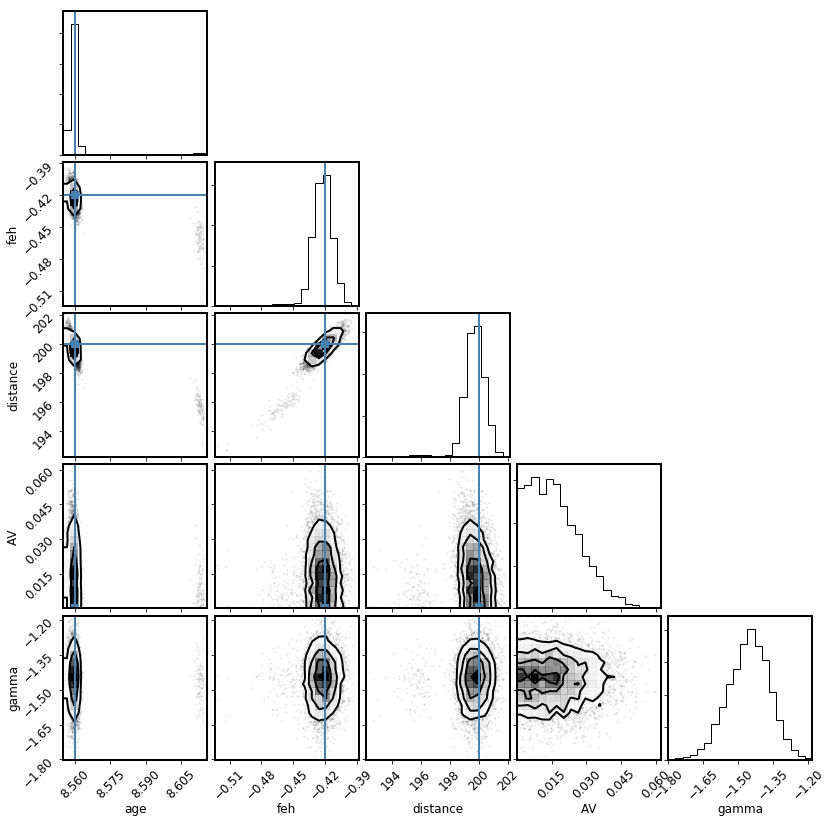

In [30]:
%matplotlib inline
import corner

names = ['age', 'feh', 'distance', 'AV', 'gamma']
fig = corner.corner(model.samples[names], names=names,
                   truths=[age, feh, distance, AV, gamma])

In [13]:
bands = 'rJK'
def band_pairs(bands):
    return [(bands[i], bands[-1]) for i in range(len(bands)-1)]
band_pairs(bands)

[('r', 'K'), ('J', 'K')]

In [14]:
def iso_compare(ic, bands, age1, feh1, dist1, AV1, 
                age2, feh2, dist2, AV2):

    def make_df(iso):
        df = pd.DataFrame()
        for b1, b2 in band_pairs(bands):
            mag1 = iso['{}_mag'.format(b1)]
            mag2 = iso['{}_mag'.format(b2)]

            df[b2] = mag2
            df['{0}-{1}'.format(b1, b2)] = mag1 - mag2
        
        return df
        
    iso1 = ic.isochrone(age1, feh1, distance=dist1, AV=AV1)
    ds1 = hv.Dataset(make_df(iso1))
    
    iso2 = ic.isochrone(age2, feh2, distance=dist2, AV=AV2)
    ds2 = hv.Dataset(make_df(iso2))
    
    layout = []
    for b1, b2 in band_pairs(bands):
        kdims = ['{}-{}'.format(b1, b2), b2]
        layout.append(hv.Points(ds1, kdims) * hv.Points(ds2, kdims))

    return hv.Layout(layout)
    

In [15]:
%%opts Points {+framewise}

from functools import partial

dmap = hv.DynamicMap(partial(iso_compare, ic=mist, bands='rJK'), 
                     kdims=['age1', 'feh1', 'dist1', 'AV1', 'age2', 'feh2', 'dist2', 'AV2'])
age_bounds = model.bounds('age')
feh_bounds = model.bounds('feh')
dist_bounds = model.bounds('distance')
dmap.redim.range(age1=age_bounds, age2=age_bounds, 
                 feh1=feh_bounds, feh2=feh_bounds,
                 dist1=dist_bounds, dist2=dist_bounds)


DynamicMap cannot be displayed without explicit indexing as 'AV1', 'AV2' dimension(s) are unbounded. 
Set dimensions bounds with the DynamicMap redim.range or redim.values methods.

:DynamicMap   [age1,feh1,dist1,AV1,age2,feh2,dist2,AV2]

In [16]:
means = model.samples.mean()
iso_compare(mist, bands='rJK', age1=age, feh1=feh, dist1=distance, AV1=AV,
            age2=means.age, feh2=means.feh, dist2=means.distance, AV2=means.AV)

:Layout
   .Overlay.I  :Overlay
      .Points.I  :Points   [r-K,K]
      .Points.II :Points   [r-K,K]
   .Overlay.II :Overlay
      .Points.I  :Points   [J-K,K]
      .Points.II :Points   [J-K,K]

In [18]:
age2, feh2, dist2, AV2, gamma2 = other_pars

In [19]:
iso_compare(mist, bands='rJK', age1=age, feh1=feh, dist1=distance, AV1=AV,
            age2=age2, feh2=feh2, dist2=dist2, AV2=AV2)

:Layout
   .Overlay.I  :Overlay
      .Points.I  :Points   [r-K,K]
      .Points.II :Points   [r-K,K]
   .Overlay.II :Overlay
      .Points.I  :Points   [J-K,K]
      .Points.II :Points   [J-K,K]

In [15]:
means = model.samples.mean()
means

age             9.493336
feh            -0.226858
distance    49877.166757
AV              0.002651
gamma          -1.358348
lnprob        -54.972238
dtype: float64

In [16]:
mean_pars = [6.85, -1.0, 13300, 0.01, -0.94]
mean_pars = [means.age, means.feh, means.distance, means.AV, means.gamma]
model.lnprior(mean_pars), model.lnlike(mean_pars), model.lnpost(mean_pars)

(-11.165645257906878, -52.74261548012587, -63.90826073803275)

In [17]:
model.lnprior(pars), model.lnlike(pars), model.lnpost(pars)

(-16.641241209353648, -186.79573788050948, -203.43697908986312)

In [19]:
%debug model.lnlike(pars)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> s
--Call--
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(76)lnlike()
     74         return lnp
     75 
---> 76     def lnlike(self, p):
     77         age = p[0]
     78         feh = p[1]

ipdb> n
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(77)lnlike()
     75 
     76     def lnlike(self, p):
---> 77         age = p[0]
     78         feh = p[1]
     79         distance = p[2]

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(78)lnlike()
     76     def lnlike(self, p):
     77         age = p[0]
---> 78         feh = p[1]
     79         distance = p[2]
     80         AV = p[3]

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(79)lnlike()
     77         age = p[0]
     78         feh = p[1]
---> 79         distance = p[2]
     80         AV = p[3]
     81         gamma = p[4]

ipdb> 
> /Users/tdm/repositories/isochrones/isochro

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(94)lnlike()
     92         ok = np.isfinite(model_masses)
     93 
---> 94         model_masses = model_masses[ok]
     95         eeps = eeps[ok]
     96 

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(95)lnlike()
     93 
     94         model_masses = model_masses[ok]
---> 95         eeps = eeps[ok]
     96 
     97         lnlike_mass = np.log(mass_fn.pdf(model_masses))

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(97)lnlike()
     95         eeps = eeps[ok]
     96 
---> 97         lnlike_mass = np.log(mass_fn.pdf(model_masses))
     98 
     99         # Compute log-likelihood of observed photometry

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(100)lnlike()
     98 
     99         # Compute log-likelihood of observed photometry
--> 100         model_mags = {b : self.ic.mag[b](eeps, age, feh, distance, AV) for b in self.bands}
    101 
    102         l

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(105)lnlike()
    103         for b in self.bands:
    104             vals = self.stars[b].values
--> 105             uncs = self.stars[b + '_unc'].values
    106 
    107             lnlike_phot += -0.5 * (vals - model_mags[b][:, None])**2 / uncs**2

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(107)lnlike()
    105             uncs = self.stars[b + '_unc'].values
    106 
--> 107             lnlike_phot += -0.5 * (vals - model_mags[b][:, None])**2 / uncs**2
    108 
    109         integrand = np.exp(lnlike_mass[:, None] + lnlike_phot)

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(103)lnlike()
    101 
    102         lnlike_phot = 0
--> 103         for b in self.bands:
    104             vals = self.stars[b].values
    105             uncs = self.stars[b + '_unc'].values

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(104)lnlike()
    102         lnlike_phot

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(114)lnlike()
    112 
    113         # Don't log a zero.
--> 114         ok = (like_tot != 0)
    115         if not ok.any():
    116             return -np.inf

ipdb> 
> /Users/tdm/repositories/isochrones/isochrones/cluster.py(115)lnlike()
    113         # Don't log a zero.
    114         ok = (like_tot != 0)
--> 115         if not ok.any():
    116             return -np.inf
    117         lnlike = np.log(like_tot[ok]).sum()

ipdb> like_tot
array([3.21015311e-03, 2.29907191e-03, 1.48631766e-02, 3.31035104e-04,
       2.93435232e-03, 1.34640436e-03, 4.68624678e-03, 8.97556563e-04,
       8.93346158e-04, 7.30555379e-03, 1.06285935e-03, 8.62753872e-03,
       1.92270572e-03, 3.11094086e-03, 1.66123822e-03, 8.67627177e-03,
       8.62511112e-04, 7.67518574e-04, 5.79266336e-03, 1.48829421e-03,
       6.67204447e-04, 3.68704256e-03, 1.63487285e-03, 1.86675657e-03,
       7.03456281e-05, 1.66416498e-03, 7.50282216e-04, 2